# Stock Portfolio Analysis Tool

Hello, with this program you can perform the following tasks:
1. Analyze the performance of a stock portfolio.
2. Compare the portfolio's performance with a benchmark.
3. Calculate performance metrics such as cumulative return, yearly return, volatility, Sharpe ratio, and Value at Risk (VaR).
4. Visualize sector weights for the portfolio and benchmark.
5. Assess the impact of adding a potential new stock to the portfolio on the VaR.
6. Perform a factor analysis on the portfolio.
7. Normalize returns and transform them to a uniform distribution.

# RULES
For safe use, I have a few rules to use the code correctly.
1. The only code where you are allowed to change stuff is "User-Defined Varibales"
2. Do not forget rule nr.1

- Within "User-Defined Variables", do not alter the variables (blue). 
- If you want to add/delete something, keep the same structure. Easiest option is to copy & paste existing code.
- I mark you the code where you can input stuff with small explanations. 

Note: If errors apprear, try first to clear all outputs, restart, run all. Then, ask Chat to explain & solve the error. 

In [1]:
# All imports for the code. DO NOT CHANGE

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tabulate import tabulate
from termcolor import colored
import statsmodels.api as sm
import requests
import zipfile
import io
from scipy.stats import gaussian_kde, percentileofscore
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick

## User-Defined Variables
Please define your portfolio, benchmark, and risk-free rate below.

In [2]:
# Portfolio value in USD
portfolio_value = 400000  # 400k USD

# Risk-free rate
risk_free_rate = 0.01  # 1% annual risk-free rate. Tbd in class.

# This is your portfolio. Set the Ticker, Weight and Timeframe. 
# To add something copy paste one line. Don't forget the ",". For the last line you don't need it
portfolio_default = [
    {'Ticker': 'AAPL', 'Weight': 0.05, 'start_date': '2023-02-01', 'end_date': '2023-12-31'},
    {'Ticker': 'MSFT', 'Weight': 0.13, 'start_date': '2020-01-01', 'end_date': '2023-12-31'},
    {'Ticker': 'GOOGL', 'Weight': 0.02, 'start_date': '2010-01-01', 'end_date': '2023-12-31'},
    {'Ticker': 'SPY', 'Weight': 0.4, 'start_date': '2000-01-01', 'end_date': '2023-12-31'},
    {'Ticker': 'IEI', 'Weight': 0.4, 'start_date': '2000-01-01', 'end_date': '2023-12-31'}
]

# This is your portfolio. Set the Ticker, Weight and Timeframe. 
# To add something copy paste one line. Don't forget the ",". For the last line you don't need it
benchmark_default = [
    {'Ticker': 'SPY', 'Weight': 0.5, 'start_date': '2000-01-01', 'end_date': '2023-12-31'},
    {'Ticker': 'IEI', 'Weight': 0.5, 'start_date': '2000-01-01', 'end_date': '2023-12-31'}
]

# Significance levels for VaR analysis
var_significance_levels = [0.01, 0.05, 0.1]

# Here, you can put in stocks for the potential VaR analysis
VaR_potential_new_stock = [
    {'Ticker': 'TSLA','Weight': 0.1,'start_date': '2020-01-01','end_date': '2023-12-31'}
]

# Set the color scheme for plots
master_style = 'fivethirtyeight'
master_colour = 'viridis'

plt.style.use(master_style)
plt.rcParams['image.cmap'] = master_colour


## User-Defined Varbiables CHECK
This code does two things:
1. It shows you your input
2. It generates an error if your weights are not adding up to 1

In [3]:
print(f"The inserted portfolio value is: {portfolio_value}$")
print(f"The inserted risk-free rate lies at: {risk_free_rate*100}%\n\n")
print(f"Chosen Ticker & Weights for the portfolio: {portfolio_default}\n")
print(f"Chosen Ticker & Weights for the benchmark: {benchmark_default}\n")
print(f"Set VaR significance levels: {var_significance_levels}\n")
print(f"Chosen stock for potential VaR: {VaR_potential_new_stock}\n")
print(f"Set master style: {master_style}\n")
print(f"Set master colour: {master_colour}\n")


# Check if weights add up to 1
def check_weights(stocks, name):
    total_weight = sum(stock['Weight'] for stock in stocks)
    if not np.isclose(total_weight, 1.0):
        raise ValueError(f"Total weight for {name} does not add up to 1. It is {total_weight:.2f}.")

check_weights(portfolio_default, "portfolio")
check_weights(benchmark_default, "benchmark")

The inserted portfolio value is: 400000$
The inserted risk-free rate lies at: 1.0%


Chosen Ticker & Weights for the portfolio: [{'Ticker': 'AAPL', 'Weight': 0.05, 'start_date': '2023-02-01', 'end_date': '2023-12-31'}, {'Ticker': 'MSFT', 'Weight': 0.13, 'start_date': '2020-01-01', 'end_date': '2023-12-31'}, {'Ticker': 'GOOGL', 'Weight': 0.02, 'start_date': '2010-01-01', 'end_date': '2023-12-31'}, {'Ticker': 'SPY', 'Weight': 0.4, 'start_date': '2000-01-01', 'end_date': '2023-12-31'}, {'Ticker': 'IEI', 'Weight': 0.4, 'start_date': '2000-01-01', 'end_date': '2023-12-31'}]

Chosen Ticker & Weights for the benchmark: [{'Ticker': 'SPY', 'Weight': 0.5, 'start_date': '2000-01-01', 'end_date': '2023-12-31'}, {'Ticker': 'IEI', 'Weight': 0.5, 'start_date': '2000-01-01', 'end_date': '2023-12-31'}]

Set VaR significance levels: [0.01, 0.05, 0.1]

Chosen stock for potential VaR: [{'Ticker': 'TSLA', 'Weight': 0.1, 'start_date': '2020-01-01', 'end_date': '2023-12-31'}]

Set master style: fivethirtyeig

## Fetch Stock Data
Fetch the historical stock data for the portfolio and benchmark.


In [4]:
# Function to validate dates and fetch stock data
def fetch_stock_data(stocks):
    stock_data = {}
    for stock in stocks:
        ticker = stock['Ticker']
        start_date = stock['start_date']
        end_date = stock['end_date']
        yf_ticker = yf.Ticker(ticker)
        hist = yf_ticker.history(start=start_date, end=end_date, auto_adjust=True, interval='1d')
        
        # Check for Adjusted Close first, then fall back to Close
        if 'Adj Close' in hist.columns:
            stock_data[ticker] = hist['Adj Close']
        elif 'Close' in hist.columns:
            stock_data[ticker] = hist['Close']
        else:
            print(f"No data found for {ticker}")
            continue
        
    return stock_data

stock_data = fetch_stock_data(portfolio_default)
benchmark_data = fetch_stock_data(benchmark_default)


## Calculate Weighted Combined Performance
Calculate the weighted combined performance of the portfolio and benchmark.


In [5]:
# Function to calculate weighted combined performance
def calculate_weighted_performance(stock_data, stocks):
    combined_performance = pd.DataFrame()
    for stock in stocks:
        ticker = stock['Ticker']
        weight = stock['Weight']
        if ticker in stock_data:
            weighted_data = stock_data[ticker] * weight
            if combined_performance.empty:
                combined_performance = weighted_data
            else:
                combined_performance = combined_performance.add(weighted_data, fill_value=0)
    return combined_performance / sum(stock['Weight'] for stock in stocks)

portfolio_combined = calculate_weighted_performance(stock_data, portfolio_default)
benchmark_combined = calculate_weighted_performance(benchmark_data, benchmark_default)


## Plot Stock Performance
Visualize the performance of individual stocks and benchmarks.


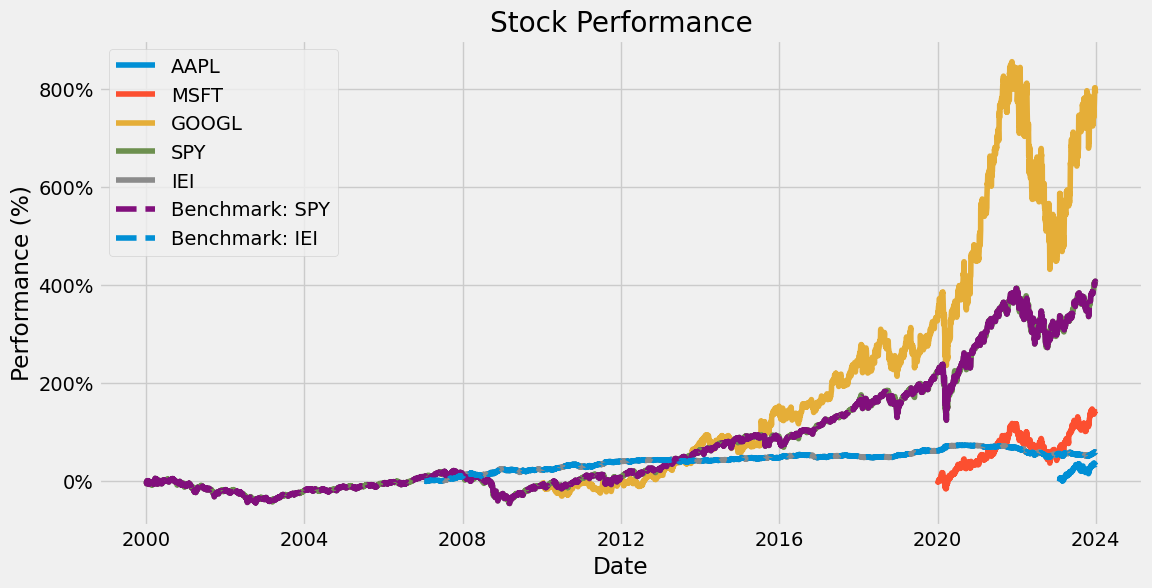

In [6]:
# Function to plot stock performance
def plot_stock_performance(stock_data, benchmark_data, portfolio_stocks, benchmark_stocks):
    plt.figure(figsize=(12, 6))
    
    # Plot portfolio stocks
    for ticker, data in stock_data.items():
        data_normalized = (data / data.iloc[0] - 1) * 100  # Normalize data to start at 0%
        plt.plot(data.index, data_normalized, label=ticker)
    
    # Plot benchmark stocks
    for ticker, data in benchmark_data.items():
        data_normalized = (data / data.iloc[0] - 1) * 100  # Normalize data to start at 0%
        plt.plot(data.index, data_normalized, label=f'Benchmark: {ticker}', linestyle='--')
    
    plt.title('Stock Performance')
    plt.xlabel('Date')
    plt.ylabel('Performance (%)')
    plt.legend(loc='upper left')
    plt.grid(True)
    
    # Format y-axis as percentage
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    
    plt.show()

plot_stock_performance(stock_data, benchmark_data, portfolio_default, benchmark_default)


## Plot Portfolio on Benchmark Performance
Visualize the combined performance of the portfolio and benchmark.


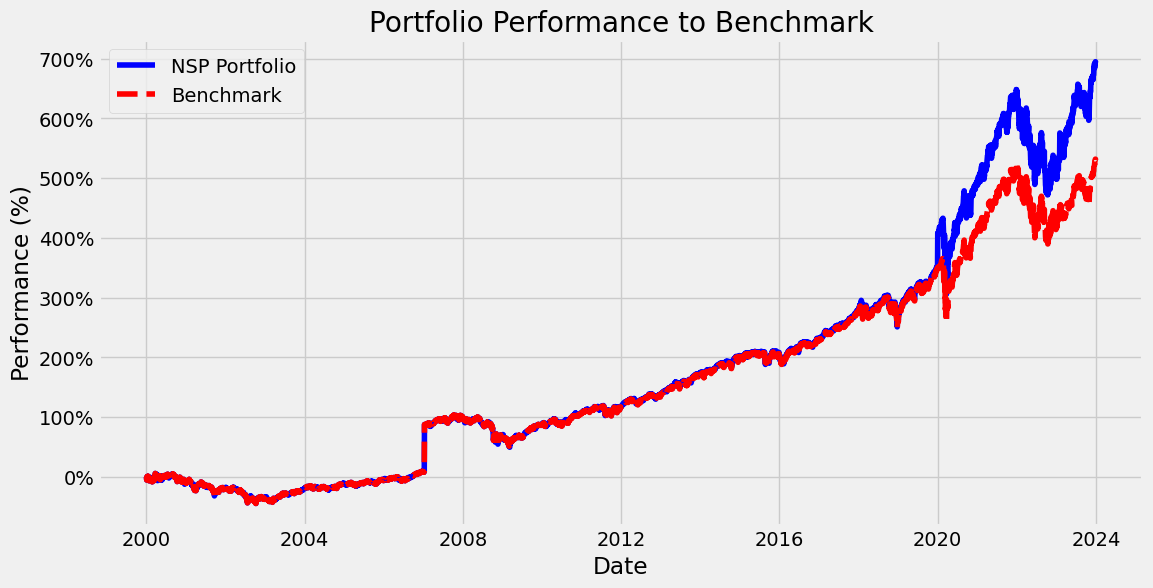

In [7]:
# Function to plot relative performance
def plot_combined_performance(portfolio_combined, benchmark_combined):
    plt.figure(figsize=(12, 6))
    
    # Plot portfolio performance (stocks combined)
    portfolio_combined_normalized = (portfolio_combined / portfolio_combined.iloc[0] - 1) * 100
    plt.plot(portfolio_combined_normalized.index, portfolio_combined_normalized, label='NSP Portfolio', color='blue', linestyle='-')
    
    # Plot benchmark performance (benchmark combined)
    benchmark_combined_normalized = (benchmark_combined / benchmark_combined.iloc[0] - 1) * 100
    plt.plot(benchmark_combined_normalized.index, benchmark_combined_normalized, label='Benchmark', color='red', linestyle='--')
    
    plt.title('Portfolio Performance to Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Performance (%)')
    plt.legend(loc='upper left')
    plt.grid(True)
    
    # Format y-axis as percentage
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    
    plt.show()

plot_combined_performance(portfolio_combined, benchmark_combined)


## Calculate Performance Metrics
Calculate various performance metrics for the portfolio and benchmark.


In [8]:
# Function to calculate performance metrics
def calculate_performance_metrics(stock_data, portfolio_value, stocks, is_portfolio=True):
    metrics = []
    portfolio_returns = pd.DataFrame()

    cumulative_return_total = 0
    yearly_return_total = 0
    volatility_total = 0
    sharpe_ratio_total = 0

    for stock in stocks:
        ticker = stock['Ticker']
        weight = stock['Weight']
        data = stock_data[ticker]
        daily_returns = data.pct_change().dropna()
        
        # Add the weighted returns to the portfolio returns DataFrame
        portfolio_returns[ticker] = daily_returns * weight

        cumulative_return = (data.iloc[-1] / data.iloc[0] - 1) * 100
        yearly_return = daily_returns.mean() * 252 * 100
        volatility = daily_returns.std() * np.sqrt(252)
        sharpe_ratio = (daily_returns.mean() - risk_free_rate / 252) / daily_returns.std() * np.sqrt(252)
        absolute_performance = (cumulative_return / 100) * portfolio_value * weight
        var_99 = np.percentile(daily_returns, 1)
        var_95 = np.percentile(daily_returns, 5)
        var_90 = np.percentile(daily_returns, 10)
        absolute_var_99 = var_99 * portfolio_value * weight
        absolute_var_95 = var_95 * portfolio_value * weight
        absolute_var_90 = var_90 * portfolio_value * weight

        cumulative_return_total += weight * cumulative_return
        yearly_return_total += weight * yearly_return
        volatility_total += weight * volatility
        sharpe_ratio_total += weight * sharpe_ratio

        metrics.append({
            'Ticker': ticker,
            'Cumulative Return (%)': cumulative_return,
            'Yearly Return (%)': yearly_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Absolute Performance (USD)': absolute_performance,
            'VaR 99%': var_99,
            'VaR 95%': var_95,
            'VaR 90%': var_90,
            'Absolute VaR 99% (USD)': absolute_var_99,
            'Absolute VaR 95% (USD)': absolute_var_95,
            'Absolute VaR 90% (USD)': absolute_var_90
        })

    if is_portfolio:
        # Calculate portfolio-level metrics
        portfolio_returns['Total'] = portfolio_returns.sum(axis=1)
        cumulative_return_portfolio = (portfolio_returns['Total'].iloc[-1] + 1 - 1) * 100
        yearly_return_portfolio = portfolio_returns['Total'].mean() * 252 * 100
        volatility_portfolio = portfolio_returns['Total'].std() * np.sqrt(252)
        sharpe_ratio_portfolio = (portfolio_returns['Total'].mean() - risk_free_rate / 252) / portfolio_returns['Total'].std() * np.sqrt(252)

        var_99_portfolio = np.percentile(portfolio_returns['Total'], 1)
        var_95_portfolio = np.percentile(portfolio_returns['Total'], 5)
        var_90_portfolio = np.percentile(portfolio_returns['Total'], 10)
        absolute_var_99_portfolio = var_99_portfolio * portfolio_value
        absolute_var_95_portfolio = var_95_portfolio * portfolio_value
        absolute_var_90_portfolio = var_90_portfolio * portfolio_value

        metrics.append({
            'Ticker': 'NSP Portfolio',
            'Cumulative Return (%)': cumulative_return_portfolio,
            'Yearly Return (%)': yearly_return_portfolio,
            'Volatility': volatility_portfolio,
            'Sharpe Ratio': sharpe_ratio_portfolio,
            'Absolute Performance (USD)': cumulative_return_total / 100 * portfolio_value,
            'VaR 99%': var_99_portfolio,
            'VaR 95%': var_95_portfolio,
            'VaR 90%': var_90_portfolio,
            'Absolute VaR 99% (USD)': absolute_var_99_portfolio,
            'Absolute VaR 95% (USD)': absolute_var_95_portfolio,
            'Absolute VaR 90% (USD)': absolute_var_90_portfolio
        })

    metrics_df = pd.DataFrame(metrics)
    return metrics_df

# Calculate performance metrics for the portfolio
performance_metrics = calculate_performance_metrics(stock_data, portfolio_value, portfolio_default, is_portfolio=True)

# Calculate performance metrics for the benchmark
benchmark_metrics = calculate_performance_metrics(benchmark_data, portfolio_value, benchmark_default, is_portfolio=False)

print("\nPortfolio Performance Metrics:")
print(tabulate(performance_metrics, headers='keys', tablefmt='psql'))

print("\nBenchmark Performance Metrics:")
print(tabulate(benchmark_metrics, headers='keys', tablefmt='psql'))



Portfolio Performance Metrics:
+----+---------------+-------------------------+---------------------+--------------+----------------+------------------------------+-------------+-------------+-------------+--------------------------+--------------------------+--------------------------+
|    | Ticker        |   Cumulative Return (%) |   Yearly Return (%) |   Volatility |   Sharpe Ratio |   Absolute Performance (USD) |     VaR 99% |     VaR 95% |     VaR 90% |   Absolute VaR 99% (USD) |   Absolute VaR 95% (USD) |   Absolute VaR 90% (USD) |
|----+---------------+-------------------------+---------------------+--------------+----------------+------------------------------+-------------+-------------+-------------+--------------------------+--------------------------+--------------------------|
|  0 | AAPL          |               33.1267   |            33.4501  |    0.197688  |       1.64148  |                      6625.34 | -0.0285299  | -0.0171764  | -0.0130402  |                 -570.

## Calculate Covariance Matrix
Calculate the covariance matrix for the portfolio stocks.

IMPORTANT:
Potentially, you have to adjust the scale_factor. The scale factor is in the last part of this code block and clearly cut from the other code.

Note: This matrix by default does not include the potential VaR stocks. However, it does if you run it again.



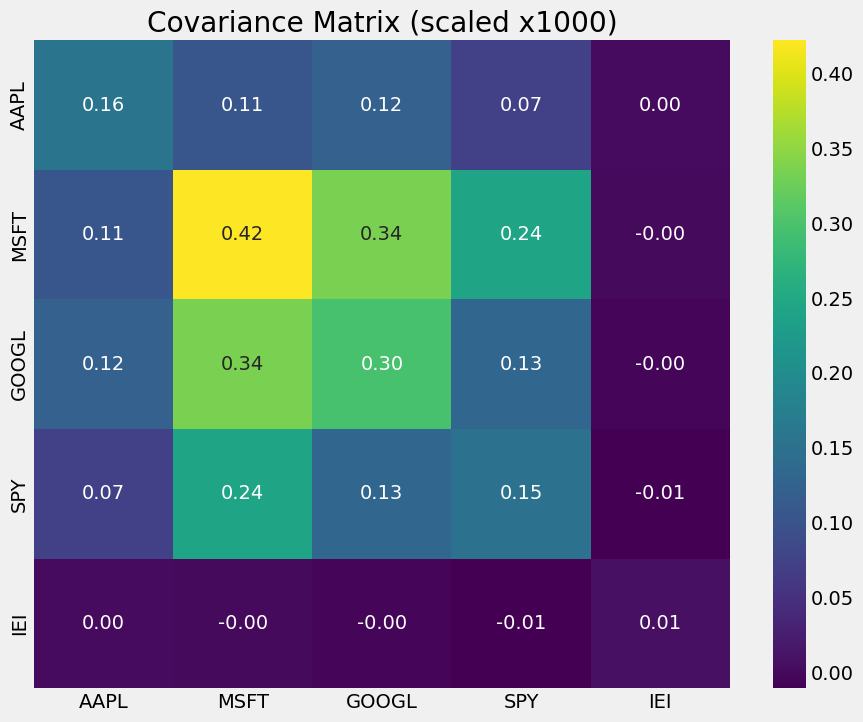

In [9]:
# Function to calculate covariance matrix and plot with scaling
def plot_scaled_covariance_matrix(stock_data, scale_factor):
    returns = pd.DataFrame({ticker: data.pct_change().dropna() for ticker, data in stock_data.items()})
    covariance_matrix = returns.cov()
    

    # Scale the covariance matrix
    scaled_covariance_matrix = covariance_matrix * scale_factor
    
    # Plotting the scaled covariance matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(scaled_covariance_matrix, annot=True, cmap=master_colour, fmt='.2f')
    plt.title(f'Covariance Matrix (scaled x{scale_factor})')
    plt.show()


#--------------------------------------------------------------------
#--------------------------------------------------------------------
#--------------------------------------------------------------------

# Potentially, you need to adjust the scale_factor as described above
scale_factor = 1000

#--------------------------------------------------------------------
#--------------------------------------------------------------------
#--------------------------------------------------------------------

# Call the function with the specified scale factor
plot_scaled_covariance_matrix(stock_data, scale_factor)




## Fetch and Plot Sector Data
Fetch the sector data for the portfolio stocks and plot the sector weights.

Note: This matrix by default does not include the potential VaR stocks. However, if you run it again it does (then it supasses the 100% allocation)

/var/folders/dd/pwf2nnyn3ds8tgggtfghzwth0000gn/T/ipykernel_11665/4010510150.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(master_colour, len(combined_sectors))


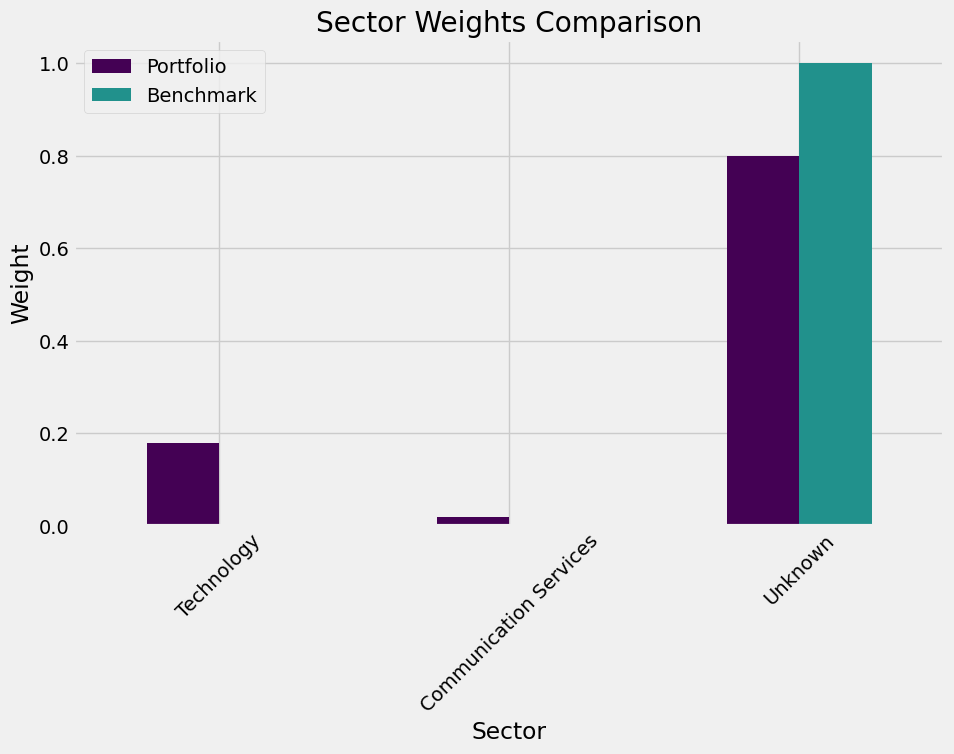

In [10]:
# Function to fetch sector data
def fetch_sector_data(stocks):
    sectors = {}
    for stock in stocks:
        ticker = stock['Ticker']
        yf_ticker = yf.Ticker(ticker)
        info = yf_ticker.info
        sector = info.get('sector', 'Unknown')
        if sector in sectors:
            sectors[sector] += stock['Weight']
        else:
            sectors[sector] = stock['Weight']
    return sectors

# Function to plot sector weights
def plot_sector_weights(portfolio_sectors, benchmark_sectors):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot portfolio sector weights
    portfolio_sectors = pd.Series(portfolio_sectors)
    benchmark_sectors = pd.Series(benchmark_sectors)
    combined_sectors = pd.concat([portfolio_sectors, benchmark_sectors], axis=1).fillna(0)
    combined_sectors.columns = ['Portfolio', 'Benchmark']
    
    # Apply color map
    colors = plt.cm.get_cmap(master_colour, len(combined_sectors))

    combined_sectors.plot(kind='bar', ax=ax, color=[colors(i) for i in range(len(combined_sectors))])
    ax.set_title('Sector Weights Comparison')
    ax.set_xlabel('Sector')
    ax.set_ylabel('Weight')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

portfolio_sectors = fetch_sector_data(portfolio_default)
benchmark_sectors = fetch_sector_data(benchmark_default)
plot_sector_weights(portfolio_sectors, benchmark_sectors)

## Potential VaR Calculation
Assess the impact of adding a potential new stock to the portfolio on the VaR.


In [11]:
# Function to calculate potential VaR with new stock
def calculate_potential_var(stock_data, portfolio_value, stocks, new_stocks):
    new_stock_data = fetch_stock_data(new_stocks)
    for new_stock in new_stocks:
        stock_data[new_stock['Ticker']] = new_stock_data[new_stock['Ticker']]
        stocks.append(new_stock)
    return calculate_performance_metrics(stock_data, portfolio_value, stocks)

potential_var_metrics = calculate_potential_var(stock_data, portfolio_value, portfolio_default, VaR_potential_new_stock)

print("\nPotential VaR with New Stock:")
print(tabulate(potential_var_metrics, headers='keys', tablefmt='psql'))



Potential VaR with New Stock:
+----+---------------+-------------------------+---------------------+--------------+----------------+------------------------------+-------------+-------------+-------------+--------------------------+--------------------------+--------------------------+
|    | Ticker        |   Cumulative Return (%) |   Yearly Return (%) |   Volatility |   Sharpe Ratio |   Absolute Performance (USD) |     VaR 99% |     VaR 95% |     VaR 90% |   Absolute VaR 99% (USD) |   Absolute VaR 95% (USD) |   Absolute VaR 90% (USD) |
|----+---------------+-------------------------+---------------------+--------------+----------------+------------------------------+-------------+-------------+-------------+--------------------------+--------------------------+--------------------------|
|  0 | AAPL          |               33.1267   |            33.4501  |    0.197688  |       1.64148  |               6625.34        | -0.0285299  | -0.0171764  | -0.0130402  |                 -570.5

## Optional: Factor Analysis
Perform a factor analysis to understand the impact of various factors (e.g., market, size, value) on the portfolio.

In [12]:
# Function to fetch Fama-French factors
def fetch_fama_french_factors(start_date, end_date):
    ff_url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip'
    
    # Download and unzip the data
    response = requests.get(ff_url, verify=False)
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        with z.open('F-F_Research_Data_Factors_daily.CSV') as f:
            # Read the raw content of the file
            raw_content = f.read().decode('utf-8')
            # Print the first few lines to inspect the structure
            print(raw_content.split('\n')[:10])
            
            # Read the content using StringIO to skip the initial rows and handle varying number of columns
            content = io.StringIO(raw_content)
            factors = pd.read_csv(content, skiprows=3)

    # Print the first few rows to inspect the columns
    print(factors.head())
    
    # Clean and filter the data
    factors.columns = factors.columns.str.strip()  # Remove any leading/trailing spaces in column names
    factors = factors.dropna().reset_index(drop=True)  # Drop any rows with missing values
    factors['Date'] = pd.to_datetime(factors.iloc[:, 0], format='%Y%m%d').dt.tz_localize(None)
    factors = factors[(factors['Date'] >= start_date) & (factors['Date'] <= end_date)]
    factors.set_index('Date', inplace=True)
    factors.drop(columns=[factors.columns[0]], inplace=True)
    
    return factors

# Fetch the Fama-French factors
start_date = datetime.strptime('2000-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2023-12-31', '%Y-%m-%d')
factors = fetch_fama_french_factors(start_date, end_date)

# Calculate the excess returns of the portfolio
portfolio_returns = portfolio_combined.pct_change().dropna()
excess_returns = portfolio_returns - (risk_free_rate / 252)

# Ensure both indexes are timezone-naive
excess_returns.index = excess_returns.index.tz_localize(None)
factors.index = factors.index.tz_localize(None)

# Align dates with the factors
aligned_data = pd.concat([excess_returns, factors], axis=1).dropna()

# Run the regression analysis
X = aligned_data[['Mkt-RF', 'SMB', 'HML']]
X = sm.add_constant(X)
y = aligned_data.iloc[:, 0]
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mba.tuck.dartmouth.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


['This file was created by CMPT_ME_BEME_RETS_DAILY using the 202403 CRSP database.\r', 'The Tbill return is the simple daily rate that, over the number of trading days\r', 'in the month, compounds to 1-month TBill rate from Ibbotson and Associates Inc.\r', '\r', ',Mkt-RF,SMB,HML,RF\r', '19260701,    0.10,   -0.25,   -0.27,   0.009\r', '19260702,    0.45,   -0.33,   -0.06,   0.009\r', '19260706,    0.17,    0.30,   -0.39,   0.009\r', '19260707,    0.09,   -0.58,    0.02,   0.009\r', '19260708,    0.21,   -0.38,    0.19,   0.009\r']
  Unnamed: 0  Mkt-RF   SMB   HML     RF
0   19260701    0.10 -0.25 -0.27  0.009
1   19260702    0.45 -0.33 -0.06  0.009
2   19260706    0.17  0.30 -0.39  0.009
3   19260707    0.09 -0.58  0.02  0.009
4   19260708    0.21 -0.38  0.19  0.009
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:          

## Optional: Normalized Returns Transformed to Uniform Distribution
This plot displays the correlation of our portfolio compared to the market /(benchmark).

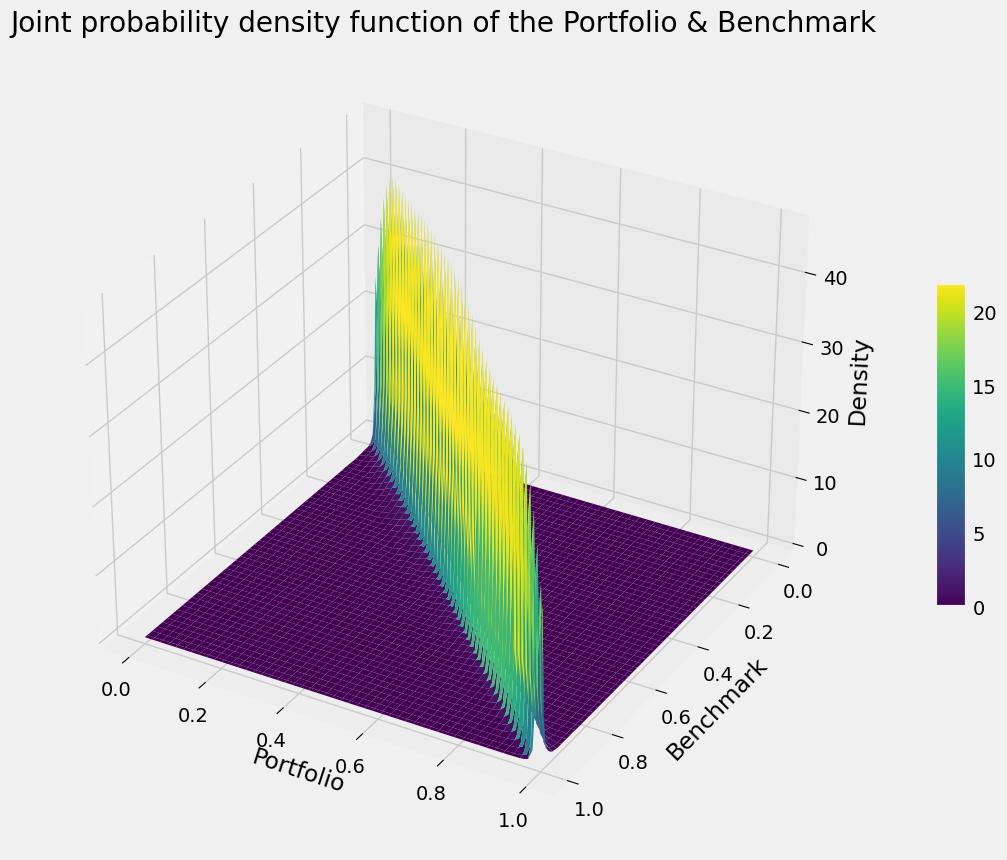

In [13]:
# Calculate the returns for portfolio and benchmark
portfolio_returns = portfolio_combined.pct_change().dropna()
benchmark_returns = benchmark_combined.pct_change().dropna()

# Combine portfolio and benchmark returns into a single DataFrame
combined_returns = pd.concat([portfolio_returns, benchmark_returns], axis=1).dropna()
combined_returns.columns = ['Portfolio', 'Benchmark']

# Transform returns to a uniform distribution via their empirical CDF
transformed_x = np.array([percentileofscore(combined_returns['Portfolio'], val, 'rank') for val in combined_returns['Portfolio']]) / 100
transformed_y = np.array([percentileofscore(combined_returns['Benchmark'], val, 'rank') for val in combined_returns['Benchmark']]) / 100

# Calculate the kernel density estimate on the transformed data
values = np.vstack([transformed_x, transformed_y])
kernel = gaussian_kde(values)

# Create a grid over which we will evaluate the KDE
u_grid, v_grid = np.mgrid[0:1:100j, 0:1:100j]
positions = np.vstack([u_grid.ravel(), v_grid.ravel()])
f = np.reshape(kernel(positions).T, u_grid.shape)

# Plotting
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(u_grid, v_grid, f, cmap=master_colour, edgecolor='none')

ax.set_xlabel('Portfolio')
ax.set_ylabel('Benchmark')
ax.set_zlabel('Density')
ax.set_title('Joint probability density function of the Portfolio & Benchmark')

# Reverse the y-axis
ax.set_ylim(ax.get_ylim()[::-1])

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.4, aspect=10)

plt.show()


## Next Steps

1. **Economic Data Integration**: Integrate economic data such as the economic calendar from sources like Yahoo Finance or other financial data providers.
2. **Monte Carlo Simulations**: Implement Monte Carlo simulations to estimate the potential future performance of the portfolio.
3. **Risk Attribution**: Conduct a risk attribution analysis to identify the sources of risk within the portfolio.
4. **Factor Analysis**: Perform a factor analysis to understand the impact of various factors (e.g., interest rates, inflation) on the portfolio.
5. **Optimization**: Optimize the portfolio by adjusting weights to maximize returns or minimize risk based on user-defined criteria.
6. **Reporting**: Create automated reports summarizing the analysis and visualizations for easy sharing and presentation.
7. **Scenario Analysis**: Conduct scenario analysis to assess the portfolio's performance under different market conditions.